In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

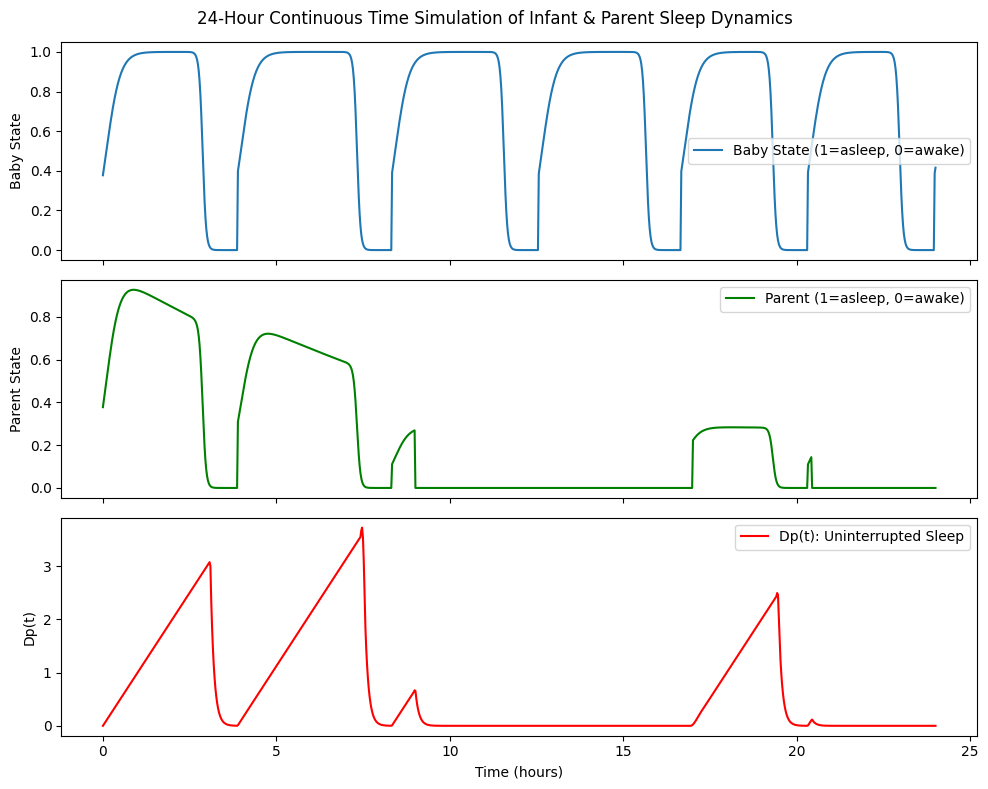

Baby total sleep:   16.81 hrs
Parent weighted sleep: 3.93 hrs
Parent raw sleep time (u > 0): 10.00 hrs
Max uninterrupted sleep proxy Dp(t): 3.72 hrs


In [19]:
np.random.seed(42)

# Constants
T = 24
K = 1.0
alpha = 0.5
gamma = 5.0  # how quickly uninterrupted sleep builds
beta = 10.0  # how quickly it decays when interrupted

# Precomputed random sleep durations
n_cycles = int(np.ceil(T / 4)) + 1
sleep_durations = np.random.uniform(2.5, 3.5, size=n_cycles)

# Baby sleep state (continuous sigmoid model)
def B(t, sleep_durations, s_asleep=5, s_awake=20):
    t = np.atleast_1d(t)
    start_times = [0]
    for dur in sleep_durations[:-1]:
        start_times.append(start_times[-1] + dur + 1.0)
    start_times = np.array(start_times)
    cycle_index = np.searchsorted(start_times, t, side='right') - 1
    cycle_index = np.clip(cycle_index, 0, len(sleep_durations) - 1)
    local_t = t - start_times[cycle_index]
    sleep_dur = np.array([sleep_durations[i] for i in cycle_index])
    fall_asleep = 1 / (1 + np.exp(-s_asleep * (local_t - 0.1)))
    wake_up = 1 / (1 + np.exp(s_awake * (local_t - sleep_dur)))
    sleep_signal = fall_asleep * wake_up
    return sleep_signal if len(sleep_signal) > 1 else sleep_signal[0]

# Time-based factors
def delta(t):
    t = np.array(t)
    return np.where((t >= 0) & (t < 8), 0.9, 0.1)

def w(t):
    return 1.0 if 9 <= t < 17 else 0.0

def Z(t):
    return np.random.normal(0, 0.1)

# Sleep control u(t)
def u(t, x_sleep, x_raw, sleep_durations):
    if x_raw >= 10:
        return 0.0  # Stop sleeping if raw sleep hits 10 hours

    sleep_need = max(0, 1 - x_sleep / 9)
    baby_factor = B(t, sleep_durations)
    night_factor = 1.0 if 0 <= t < 8 else 0.5
    work_factor = 0.0 if w(t) == 1 else 1.0
    return np.clip(sleep_need * baby_factor * night_factor * work_factor, 0.0, 1.0)

# Updated ODE with 3 states: [x_sleep, dp, x_raw]
def sleep_ode_with_dp(t, x, sleep_durations):
    x_sleep, dp, x_raw = x
    u_t = u(t, x_sleep, x_raw, sleep_durations)
    b_t = B(t, sleep_durations)

    dxdt = delta(t) * u_t * b_t
    drdt = 1.0 if u_t > 0.01 else 0.0  # Unweighted sleep counter
    dpdt = 1.0 if u_t > 0.01 else -beta * dp  # Uninterrupted sleep tracker

    return [dxdt, dpdt, drdt]

# Time vector
t_eval = np.linspace(0, T, 1000)

# Solve ODEs
sol = solve_ivp(sleep_ode_with_dp, [0, T], [0, 0, 0], args=(sleep_durations,), t_eval=t_eval)
t_vals = sol.t
x_vals = sol.y[0]       # weighted sleep
dp_vals = sol.y[1]      # uninterrupted
raw_sleep_vals = sol.y[2]  # unweighted sleep time (u > 0)

# Reconstruct u(t)
u_vals = np.array([u(t, x, r, sleep_durations) for t, x, r in zip(t_vals, x_vals, raw_sleep_vals)])
b_vals = B(t_vals, sleep_durations)

# Cost and plots
w_vals = np.array([w(t) for t in t_vals])
z_vals = np.array([Z(t) for t in t_vals])
d_vals = delta(t_vals)
integrand = b_vals * u_vals**2 / (K + 0.01) - w_vals + alpha * z_vals
cost = np.trapz(integrand, t_vals)
du_dt = np.diff(u_vals) / np.diff(t_vals)
switching_penalty = np.sum(np.abs(du_dt)) * (t_vals[1] - t_vals[0])
lambda_reg = 1.0
cost += lambda_reg * switching_penalty

# Plot
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

ax[0].plot(t_vals, b_vals, label='Baby State (1=asleep, 0=awake)')
ax[0].set_ylabel('Baby State')
ax[0].legend()

ax[1].plot(t_vals, u_vals, label='Parent (1=asleep, 0=awake)', color='green')
ax[1].set_ylabel('Parent State')
ax[1].legend()

ax[2].plot(t_vals, dp_vals, label='Dp(t): Uninterrupted Sleep', color='red')
ax[2].set_ylabel('Dp(t)')
ax[2].set_xlabel('Time (hours)')
ax[2].legend()

fig.suptitle(f'24-Hour Continuous Time Simulation of Infant & Parent Sleep Dynamics')
plt.tight_layout()
plt.show()

# Summary
print(f"Baby total sleep:   {np.trapz(b_vals, t_vals):.2f} hrs")
print(f"Parent weighted sleep: {x_vals[-1]:.2f} hrs")
print(f"Parent raw sleep time (u > 0): {raw_sleep_vals[-1]:.2f} hrs")
print(f"Max uninterrupted sleep proxy Dp(t): {np.max(dp_vals):.2f} hrs")
